In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats

from sklearn.linear_model import LogisticRegression

In [51]:
df = pd.read_csv("../data/sherbank-housing/train.csv")
df.shape

(30471, 292)

In [52]:
cols = ["id","life_sq","full_sq","build_year","num_room","timestamp","price_doc"]
nearby_features = ["office"]
prediction_cols = ["life_sq","build_year","num_room","transaction_year","log_life_sq"] + nearby_features


## Improving Features


### Drop Bad Rows From Training Set

In [53]:
#df[(pd.isnull(df["life_sq"]) | df["life_sq"]==0) & (pd.isnull(df["full_sq"]) | df["full_sq"]==0)].head(100)
df[df["id"]==17935]
df[df["id"]==6115]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
6112,6115,2013-02-22,6,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,7,1,0,12,1,5177040


In [54]:
df.drop(df.index[[6115,17932]], inplace=True)
# df.dropna(thresh=5)
# df[df["life_sq"]==0].head()
# df[df["life_sq"]==0].head()


### Process missing Values - Impute
- [Pandas link](http://pandas.pydata.org/pandas-docs/stable/missing_data.html)
- [Sklearn Imputer with pipeline](http://scikit-learn.org/stable/auto_examples/missing_values.html)
- [Checking nans SO](http://stackoverflow.com/questions/34779961/scikit-learn-error-in-fitting-model-input-contains-nan-infinity-or-a-value)
- [Replacing missing values fillna pandas](http://stackoverflow.com/questions/29177498/python-pandas-replace-nan-in-one-column-with-value-from-corresponding-row-of-sec)

In [55]:
def lowValueReplacer(df_features):
    df_features.loc[df_features.life_sq <= 10, 'life_sq'] = df_features.num_room * 10
    df_features.loc[df_features.life_sq <= 10, 'life_sq'] = df_features.full_sq.shift(0)
    return df_features
    
def zeroReplacerWithNan(df_features):
    df_features["life_sq"].replace(0,np.nan,inplace=True)
    return df_features

def imputer(df_features):
    df_features = zeroReplacerWithNan(df_features)
    df_features["life_sq"].fillna(df_features["full_sq"]-15,inplace=True)
    df_features = lowValueReplacer(df_features)
    df_features["num_room"].fillna(df_features["life_sq"]/14,inplace=True)
    df_features = df_features.fillna(df_features.median())
    return df_features

df = imputer(df)






# df_features.mean()

### Outlier Removal

- [Quantile based removal - SO](http://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles)
- [Remove all rows based on STD](http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe)

In [56]:
def oulierRemover(df_features):
    df_features[np.abs(df_features.life_sq-df_features.life_sq.mean())<=700]
    return df_features

## Below outlier remover only works on training set as it removes extreme values of the predicted variable
def oulierRemover_train(df_features):
    df_features[df_features.price_doc-df_features.price_doc.mean()<=(6*df_features.price_doc.std())]
    return df_features

df = oulierRemover(df)
df = oulierRemover_train(df)
# df_features[np.abs(df_features.life_sq-df_features.life_sq.mean())<=(6*df_features.life_sq.std())]

# df_features[np.abs(df_features.price_doc-df_features.price_doc.mean())<=(5*df_features.price_doc.std())]

# Removing all columns with outliers using z scores
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]



### Adding new Features

In [57]:
def featureAdder(df_features):
    df_features['date_column'] = pd.to_datetime(df_features['timestamp'])
    df_features["transaction_year"] = df_features['date_column'].map(lambda x: x.year)
    df_features["log_life_sq"] = np.log(df_features["life_sq"])
    return df_features

df = featureAdder(df)

### Feature Transformations
- for polynomial regression see [Polynomial Regression SO](http://stackoverflow.com/questions/32660231/how-to-fit-a-polynomial-curve-to-data-using-scikit-learn)

In [58]:
# df_features["life_sq"] = np.log(df_features["life_sq"])
# predicted_col_name = price_doc here

def gen_log_columns(f_name,df):
    colnames = df.columns[pd.Series(df.columns).str.startswith(f_name)]
    cnames = colnames.values.tolist()
    #cnames=[]
    for colname in colnames:
        log_col = "%s_log"%colname
        df[log_col] = np.log(df[colname]+1)
        square_root_col = "%s_square_root"%colname
        df[square_root_col] = df[colname]**0.5
        square_col = "%s_square"%colname
        df[square_col] = df[colname]**2
        cube_col = "%s_cube"%colname
        df[cube_col] = df[colname]**3
        cnames += [log_col,square_col,cube_col,square_root_col]
    return cnames

def fit_nearby_feature(f_name,predicted_col_name,df):
    cnames = gen_log_columns(f_name,df)
    regr = linear_model.LinearRegression(copy_X=True,n_jobs=2,normalize=True)
    X = df[cnames].values
    y = df[predicted_col_name].values
    regr.fit(X, y)
    return {"model":regr,"cols":cnames}

def add_nearby_feature(f_name,df,model,cnames):
    X = df[cnames].values
    df[f_name] = model.predict(X)
    df[f_name] = (df[f_name]-df[f_name].mean())/df[f_name].std()

nearby_models = {}

def train_transform(df):
    for f_name in nearby_features:
        f = fit_nearby_feature(f_name,"price_doc",df)
        nearby_models[f_name]= f
        add_nearby_feature(f_name,df,f["model"],f["cols"])
        return df
        
df = train_transform(df)
    
def test_transform(df_test):
    for f_name in nearby_features:
        cnames = gen_log_columns(f_name,df_test)
        add_nearby_feature(f_name,df_test,nearby_models[f_name]["model"],nearby_models[f_name]["cols"])
    return df_test

In [59]:
df[prediction_cols+['price_doc']].head()

,life_sq,build_year,num_room,transaction_year,log_life_sq,office,price_doc
0,27.0,1979.0,1.928571,2011,3.295837,-0.344406,5850000
1,19.0,1979.0,1.357143,2011,2.944439,0.578505,6000000
2,29.0,1979.0,2.071429,2011,3.367296,0.082122,5700000
3,50.0,1979.0,3.571429,2011,3.912023,-0.379407,13100000
4,77.0,1979.0,5.500000,2011,4.343805,3.505399,16331452


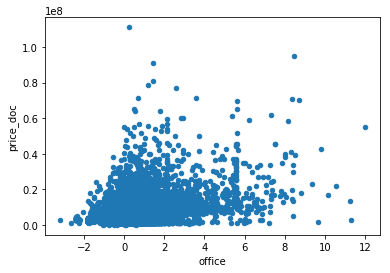

In [60]:
df.plot.scatter(x="office",y="price_doc")
plt.show();

## Model Build and Test

### Split train test

In [61]:
X = df[prediction_cols].values
y = df["price_doc"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

np.isnan(X).any()

False

In [62]:
df[np.isnan(df["log_life_sq"])].head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,office_sqm_3000_cube,office_count_5000_log,office_count_5000_square_root,office_count_5000_square,office_count_5000_cube,office_sqm_5000_log,office_sqm_5000_square_root,office_sqm_5000_square,office_sqm_5000_cube,office


### Build model and generate predictions on split test 

In [63]:


# Create linear regression object
regr = linear_model.LinearRegression(copy_X=True,n_jobs=2,normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

def predict(X):
    y_pred = regr.predict(X)
    y_pred[y_pred < 10] = np.mean(y_pred)
    return y_pred

y_pred = predict(X_test)



In [64]:
eps = 1e-7
np.isnan(y_test).any()
np.any(np.absolute(y_pred) < eps)
np.log(y_test)



array([ 15.86963429,  16.18107045,  16.05622025, ...,  15.67180855,
        14.78569688,  15.52894806])

### Errors RMSE and RMSLE for train data

In [65]:
def findRMSLE(y_true,y_pred):
    return mean_squared_error(np.log(y_true), np.log(y_pred))

print('RMSLE: %.3f' % (findRMSLE(y_test, y_pred)))
print("RMSE: %.3f" % mean_squared_error(y_test, y_pred)**0.5)

RMSLE: 0.309
RMSE: 3439384.549


## Using Model on Test Set to generate prediction csv

In [66]:
df_test = pd.read_csv("../data/sherbank-housing/test.csv")
df_test.shape

(7662, 291)

### Extracting features and applying same transformations that were done on training data

In [67]:
df_test = imputer(df_test)
df_test = oulierRemover(df_test)
df_test = featureAdder(df_test)
df_test = test_transform(df_test)

In [68]:
df_test[prediction_cols].head()

,life_sq,build_year,num_room,transaction_year,log_life_sq,office
0,20.7,1998.0,1,2015,3.030134,-0.721701
1,64.2,0.0,3,2015,4.162003,-0.558584
2,25.1,1960.0,2,2015,3.222868,-0.235220
3,36.0,2016.0,2,2015,3.583519,-0.994863
4,40.0,0.0,1,2015,3.688879,-0.698538


In [69]:
X_t = df_test[prediction_cols].values
y_t = predict(X_t)

### Generate Predictions

In [70]:
ids =np.array(df_test["id"]).astype(int)
my_solution = pd.DataFrame(y_t, ids, columns = ["price_doc"])
print(my_solution.shape)


          price_doc
30474  4.527438e+06
30475  9.782210e+06
30476  6.733284e+06
30477  6.391772e+06
30478  6.783539e+06
(7662, 1)


### Save to CSV

In [71]:
my_solution.to_csv("../data/sherbank-housing/results/my_solution_one.csv", index_label = ["id"])